<a href="https://colab.research.google.com/github/nhlong1512/IS403.N21/blob/main/Lab5/ARIMAX_Final07052023_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

Đọc dữ liệu

In [48]:
dff = pd.read_excel('VCB.xlsx')
vcb_data = dff.loc[::-1].reset_index(drop=True)
print(vcb_data)
dff = pd.read_excel('VNIndex.xlsx')
vnindex_data = dff.loc[::-1].reset_index(drop=True)
print(vnindex_data)

                    Ngày  Lần cuối     Mở    Cao   Thấp       KL  % Thay đổi
0    2022-04-01 00:00:00     79000  79000  79400  78000    1.13M      0.0025
1    2022-05-01 00:00:00     78000  79000  80400  78000    1.60M     -0.0127
2    2022-06-01 00:00:00     79100  78600  79900  77900    1.22M      0.0141
3    2022-07-01 00:00:00     79800  79600  79900  78200  966.20K      0.0088
4    2022-10-01 00:00:00     79500  79700  79900  78500    1.10M     -0.0038
..                   ...       ...    ...    ...    ...      ...         ...
333  2023-11-05 00:00:00     90800  92000  92300  90800  460.90K     -0.0077
334  2023-12-05 00:00:00     93000  91500  93000  90800  602.90K      0.0242
335           15/05/2023     91300  92800  93000  91200  419.60K     -0.0183
336           16/05/2023     93000  92000  93100  91100  647.70K      0.0186
337           17/05/2023     92600  92600  93000  92100  501.50K     -0.0043

[338 rows x 7 columns]
                    Ngày  Mở-VNINDEX
0    2022-04-01

Dữ liệu BTC-USD

In [49]:
vcb_data.head()

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
0,2022-04-01 00:00:00,79000,79000,79400,78000,1.13M,0.0025
1,2022-05-01 00:00:00,78000,79000,80400,78000,1.60M,-0.0127
2,2022-06-01 00:00:00,79100,78600,79900,77900,1.22M,0.0141
3,2022-07-01 00:00:00,79800,79600,79900,78200,966.20K,0.0088
4,2022-10-01 00:00:00,79500,79700,79900,78500,1.10M,-0.0038


Dữ liệu ETH-USD

In [50]:
vnindex_data.head()

,Ngày,Mở-VNINDEX
0,2022-04-01 00:00:00,1508.55
1,2022-05-01 00:00:00,1525.58
2,2022-06-01 00:00:00,1522.50
3,2022-07-01 00:00:00,1534.10
4,2022-10-01 00:00:00,1528.48


Kết hợp dữ liệu BTC và ETH

In [51]:
data = pd.merge(vcb_data, vnindex_data, on='Ngày')
data.head()

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi,Mở-VNINDEX
0,2022-04-01 00:00:00,79000,79000,79400,78000,1.13M,0.0025,1508.55
1,2022-05-01 00:00:00,78000,79000,80400,78000,1.60M,-0.0127,1525.58
2,2022-06-01 00:00:00,79100,78600,79900,77900,1.22M,0.0141,1522.50
3,2022-07-01 00:00:00,79800,79600,79900,78200,966.20K,0.0088,1534.10
4,2022-10-01 00:00:00,79500,79700,79900,78500,1.10M,-0.0038,1528.48


**<h3>Dự đoán ARIMAX 7-2-1</h3>**

In [52]:

# data = data.reset_index(drop=True) # Reset the index
data['Ngày'] = pd.to_datetime(data['Ngày'])
# data.set_index('Ngày', inplace=True)
data = data[['Mở', 'Mở-VNINDEX']]
data = data.dropna() # Drop missing values

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]
print(len(train_data))
print(len(test_data))
print(len(val_data))

236
67
35


<ipython-input-52-8fe7da18c3ce>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Ngày'] = pd.to_datetime(data['Ngày'])


In [53]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
from pmdarima.arima import auto_arima
train_exog = train_data[["Mở-VNINDEX"]]
model = auto_arima(train_data['Mở'], 
                      test='adf',       # use adftest to find      
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,  
                      stepwise=True,
                      exogenous= train_exog)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4142.808, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4136.008, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4137.630, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4137.628, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4134.012, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4139.587, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.790 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  236
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2066.006
Date:                Wed, 17 May 2023   AIC                           4134.012
Time:                        07:49:12   BIC                           4137.471
Sample:                             0   HQIC                          4135.406
          

In [55]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_data['Mở'], 
 exog=train_exog,
 order=(2,1,2),
 enforce_invertibility=False, enforce_stationarity=False)

In [56]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Mở'])
test_exog = test_data[['Mở-VNINDEX']]
model_fit = model.fit()
# y_pred = model.predict(n_periods=len(y_test))
y_pred = model_fit.forecast(steps=len(y_test), exog=test_exog)
print(y_pred)

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Mở'])
val_exog = val_data[['Mở-VNINDEX']]
print(val_exog)
y_pred_val =  model_fit.forecast(steps=len(y_val), exog=val_exog)
print(y_pred_val)

236    78741.796664
237    78787.621538
238    79033.889947
239    78896.702362
240    78287.588164
           ...     
298    78477.476598
299    77544.109394
300    77939.216580
301    78282.659130
302    78475.764872
Name: predicted_mean, Length: 67, dtype: float64
     Mở-VNINDEX
303     1047.78
304     1052.25
305     1054.29
306     1056.33
307     1059.44
308     1064.64
309     1079.28
310     1078.45
311     1080.86
312     1070.91
313     1073.86
314     1065.35
315     1071.61
316     1069.45
317     1064.30
318     1052.89
319     1053.81
320     1055.02
321     1048.98
322     1049.25
323     1042.91
324     1045.87
325     1034.85
326     1040.80
327     1043.17
328     1049.12
329     1040.61
330     1040.31
331     1055.42
332     1055.62
333     1058.26
334     1057.12
335     1066.90
336     1065.71
337     1065.91
236    78755.771682
237    78918.478529
238    78990.270950
239    79059.744244
240    79178.601461
241    79386.627922
242    79996.385378
243    79952.07

In [58]:
import datetime

# 6. Quá trình tạo index predict 6 ngày tiếp theo
last_index =  data.index[-1]
print(last_index)
# last_data = pd.RangeIndex(start=last_index, stop=last_index+6, step=1)
next_6_days_index = pd.RangeIndex(start=last_index,stop=last_index+6,step=1)


print(next_6_days_index)
x_next_6_days = np.array(next_6_days_index).reshape(-1, 1)

prev_6_days_exog = data[len(data)-6:]
prev_6_days_exog = prev_6_days_exog['Mở-VNINDEX']


# Predict the closing prices for the next 6 days
# y_next_6_days = model.predict(n_periods=len(x_next_6_days)) 
y_next_6_days = model_fit.forecast(steps=len(x_next_6_days), exog = prev_6_days_exog) 

# Print the predicted closing prices for the next 6 days
print('Predicted closing prices for the next 6 days:')
print(y_next_6_days)

337
RangeIndex(start=337, stop=343, step=1)
Predicted closing prices for the next 6 days:
236    79087.784241
237    79172.993259
238    79110.117320
239    79507.368319
240    79444.126811
241    79440.410568
Name: predicted_mean, dtype: float64


Validation RMSE: 11349.5558571484
Testing RMSE: 10730.534428523435
Validation MAPE: 0.12413326924084872
Testing MAPE: 0.10653160833366314


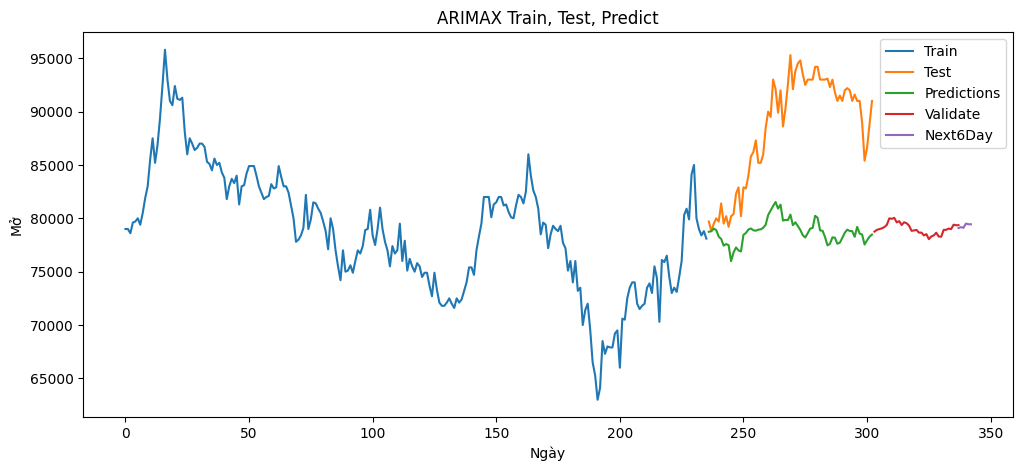

In [59]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))  # MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))  # MAPE
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)



# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Mở');
plt.xlabel('Ngày');
plt.title('ARIMAX Train, Test, Predict')
plt.plot(train_data.index, train_data['Mở'])
plt.plot(test_data.index, test_data['Mở'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
# plt.plot(last_data,y_next_6_days)
plt.plot(next_6_days_index,y_next_6_days)

plt.legend(['Train', 'Test', 'Predictions','Validate','Next6Day'])
plt.show()